In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

#================ LOAD DATA AND PREPROCESS ==================
def load_data(filepath):
    df = pd.read_csv(filepath)
    df.dropna(inplace=True)  # Drop missing values
    x = df.select_dtypes(include=[np.number])  # Use only numeric features
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    return df, x_scaled

#================ FOR PCA Dimensionality reduction =========
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x)

    # Plot explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Component')
    plt.grid(True)
    plt.show()

    return x_pca, pca

#================ FOR K-Means ===============================
def find_optimal_clusters(x, max_clusters=10):
    inertias = []
    silhouettes = []
    cluster_range = range(2, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(x, labels))

    # Plot Inertia
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, inertias, marker='o')
    plt.title('Inertia Plot (Elbow Method)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, silhouettes, marker='o', color='orange')
    plt.title('Silhouette Score Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')

    plt.tight_layout()
    plt.show()

def perform_kmeans_clustering(x, n_clusters=None):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x)
    return labels, kmeans

#================ FOR Agglomerative ===============================
def perform_agglomerative_clustering(x, n_clusters=None):
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(x)
    return labels

#================FOR Dendrogram===============================
def get_linkages(x):
    return linkage(x, method='ward')

def plot_dendrogram(linked):
    plt.figure(figsize=(10, 6))
    dendrogram(linked, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')
    plt.show()


## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    1. Load the CSV file (semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Load data
    df = pd.read_csv(filepath, sep=';')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                        'loan', 'contact', 'month', 'poutcome', 'y']

    # Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
                'housing', 'loan', 'default']
    X = df[features]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


In [29]:
import numpy as np

class KMeansClustering:
    """Minimal K-means implementation for clustering."""

    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) == 0:
                # Reinitialize empty cluster centroid
                new_centroid = X[np.random.choice(X.shape[0])]
            else:
                new_centroid = cluster_points.mean(axis=0)
            new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)

            # Check for convergence
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break

            self.centroids = new_centroids

        self.labels = self._assign_clusters(X)
        return self

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

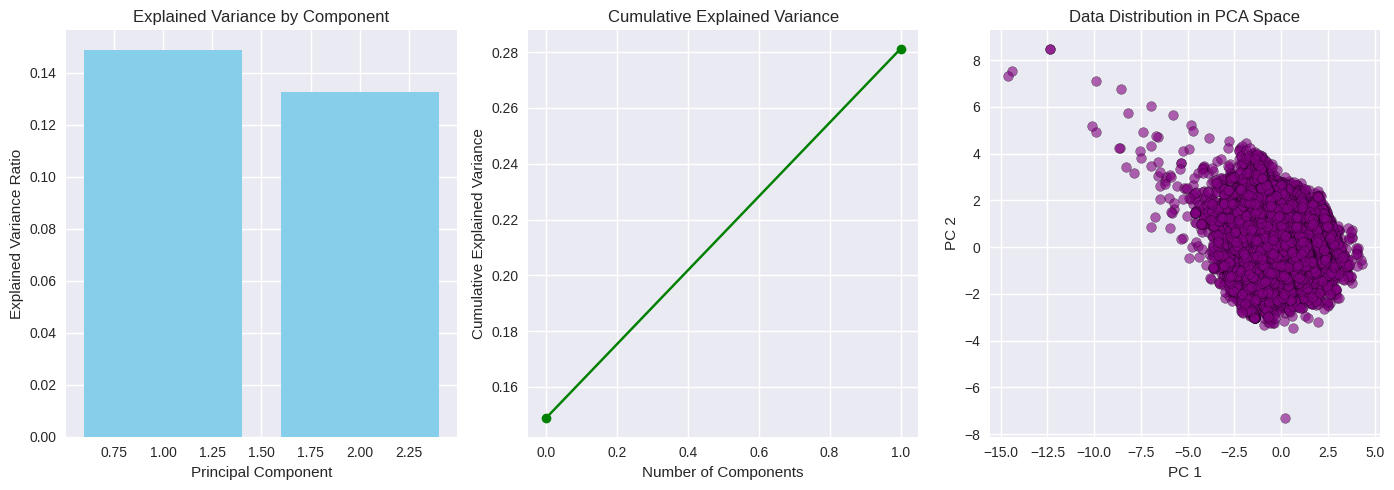

Shape after PCA: (45211, 2)


In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Initialize and fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Create visualizations
    plt.figure(figsize=(14, 5))

    # Explained variance ratio
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_, color='skyblue')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    plt.grid(True)

    # Cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='green')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.grid(True)

    # Data distribution in 2D PCA space
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='purple', edgecolor='k')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Data Distribution in PCA Space')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)


## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

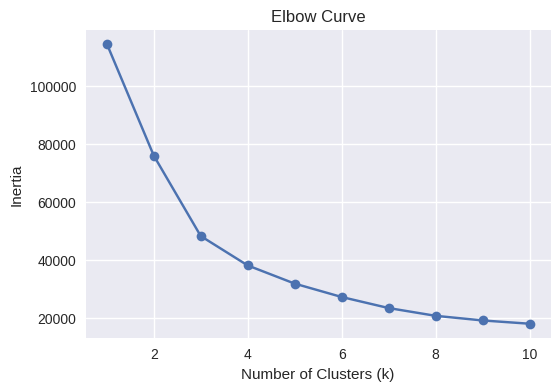

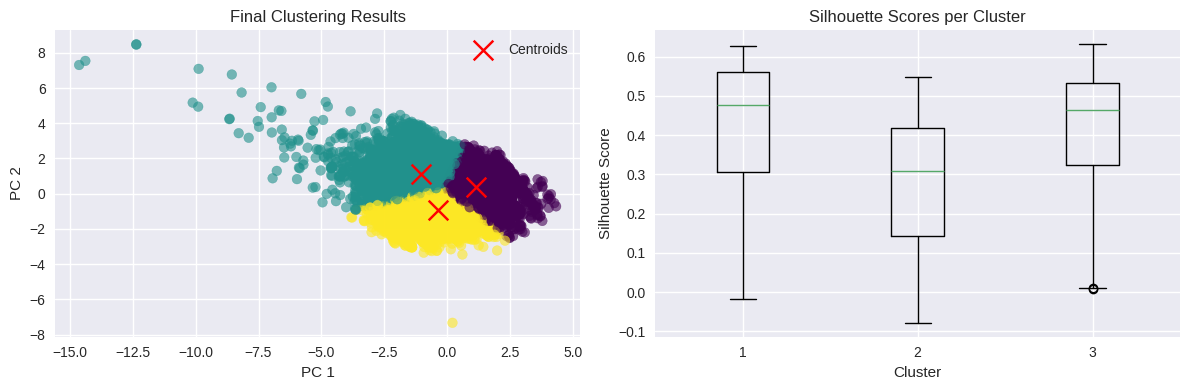


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [31]:
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        inertia += np.sum(distances ** 2)
    return inertia

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters."""
    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        kmeans = KMeansClustering(n_clusters=k)
        kmeans.fit(X)
        inertia = calculate_inertia(X, kmeans.labels, kmeans.centroids)
        inertias.append(inertia)

    # Create elbow plot
    plt.figure(figsize=(6, 4))
    plt.plot(K, inertias, marker='o')
    plt.title('Elbow Curve')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Adjust based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()

# Plot silhouette scores per sample
plt.subplot(1, 2, 2)
sample_silhouettes = silhouette_samples(X_pca, kmeans.labels)
plt.boxplot([sample_silhouettes[kmeans.labels == i] for i in range(kmeans.n_clusters)])
plt.title('Silhouette Scores per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")


## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

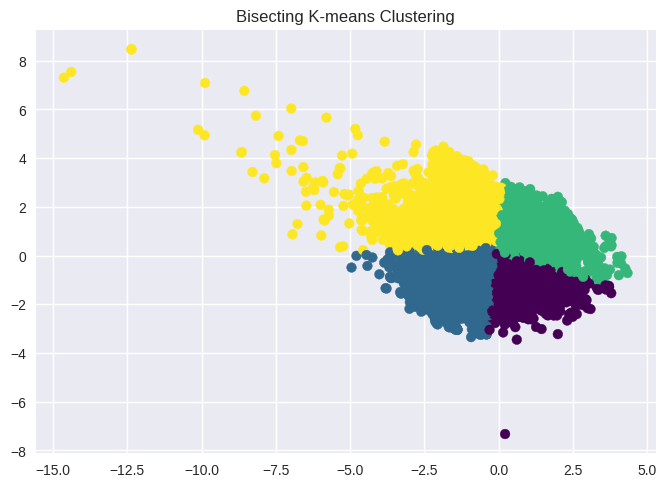

In [32]:
import numpy as np
from sklearn.cluster import KMeans

class BisectingKMeans:
    """Bisecting K-means implementation using recursive binary splits."""

    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}
        self.centers_ = {}

    def fit_predict(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        current_clusters = {0: np.arange(n_samples)}
        next_label = 1

        while len(current_clusters) < self.n_clusters:
            # Select the largest cluster to split
            largest_label = max(current_clusters, key=lambda k: len(current_clusters[k]))
            indices_to_split = current_clusters[largest_label]
            X_subset = X[indices_to_split]

            # Apply binary KMeans
            kmeans = KMeans(n_clusters=2, random_state=self.random_state)
            split_labels = kmeans.fit_predict(X_subset)

            # Map split labels to global labels
            left_indices = indices_to_split[split_labels == 0]
            right_indices = indices_to_split[split_labels == 1]

            # Keep one label as original, assign new label to the other
            current_clusters[largest_label] = left_indices
            current_clusters[next_label] = right_indices

            # Update global labels
            self.labels_[right_indices] = next_label

            # Record split tree and centroids
            self.split_tree[largest_label] = (largest_label, next_label)
            self.centers_[largest_label] = kmeans.cluster_centers_[0]
            self.centers_[next_label] = kmeans.cluster_centers_[1]

            next_label += 1

        return self.labels_

bisect = BisectingKMeans(n_clusters=4)
labels = bisect.fit_predict(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('Bisecting K-means Clustering')
plt.show()


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!